<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/All_the_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install opendatasets

In [61]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/himanshunakrani/iris-dataset")

Skipping, found downloaded files in "./iris-dataset" (use force=True to force download)


In [62]:
df= pd.read_csv("/content/iris-dataset/iris.csv")

In [63]:
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [64]:
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['species'])

# Appending the array to our dataFrame
# with column name 'Purchased'
df["y"] = label
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


In [65]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df)
df_shuffled.head()

,sepal_length,sepal_width,petal_length,petal_width,species,y
9,4.9,3.1,1.5,0.1,setosa,0
73,6.1,2.8,4.7,1.2,versicolor,1
28,5.2,3.4,1.4,0.2,setosa,0
144,6.7,3.3,5.7,2.5,virginica,2
84,5.4,3.0,4.5,1.5,versicolor,1


In [66]:
y = df_shuffled["y"].to_numpy()
X = df_shuffled.copy().drop(["species","y"],axis=1).to_numpy()

**Standardize the data**


In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Trainning

In [68]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [69]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
output = classifier.fit(X_train, y_train)
print(f'Train output: {output.score(X_train, y_train)}')
print(f'Test output: {output.score(X_test,y_test)}')


Train output: 0.975
Test output: 0.9666666666666667


**Model explain: PermutationImportance**

In [70]:
!pip install eli5

In [71]:
import eli5
from eli5.sklearn import PermutationImportance
dummy_df = df_shuffled.copy().drop(["species","y"],axis=1)

perm = PermutationImportance(classifier, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = dummy_df.columns.to_list(),)


Weight,Feature
0.2067 ± 0.0777,petal_width
0.1667 ± 0.0730,petal_length
0.0733 ± 0.0777,sepal_width
0.0267 ± 0.0499,sepal_length


**Model Explainability with Shap** [link text](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html)

(30, 4)


<ipython-input-72-f0a73e0c228f>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values)


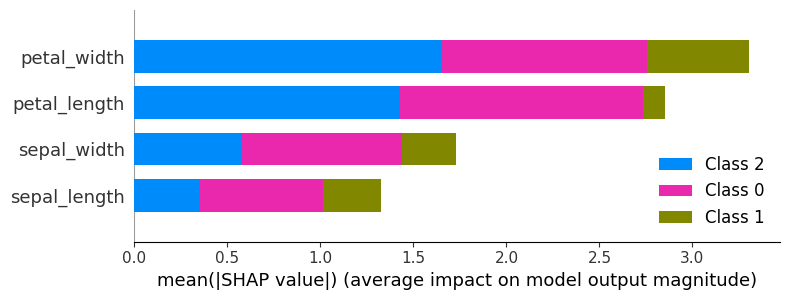

In [72]:
import shap

# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(classifier, X_test, feature_names=dummy_df.columns)
shap_values = explainer(X_test)
print(shap_values.data.shape)

# visualize the model's dependence on the first feature
shap.summary_plot(shap_values)

In [73]:
!pip install skl2onnx

**Model optimization ONNX**

In [74]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(classifier, initial_types=initial_type)

with open("rf_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [75]:
!pip install onnxruntime

Model Inference from ONNX model

In [76]:
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score
# Load ONNX model
session = ort.InferenceSession("rf_model.onnx")

# Prepare input
input_name = session.get_inputs()[0].name
input_data = X_test.astype(np.float32)

# Run inference
preds = session.run(None, {input_name: input_data})[0]
print(accuracy_score(y_test, preds))

0.9666666666666667


In [77]:
import torch
from torch.nn import functional as F
from torch import nn

torch_model = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
)
torch_model.compile()
print(torch_model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=3, bias=True)
)


In [78]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

In [79]:
from torch import optim
from torch import nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = torch_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

Epoch [20/100], Loss: 0.0072
Epoch [40/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0008
Epoch [80/100], Loss: 0.1028
Epoch [100/100], Loss: 0.0000


In [80]:
torch_model.eval()
with torch.no_grad():
    outputs = torch_model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(y_test_tensor, predicted)
    print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 96.67%


In [81]:
!pip install torch torchviz graphviz


In [82]:
from torchviz import make_dot
sample_input = X_test_tensor[0].unsqueeze(0)
make_dot(torch_model(sample_input), params=dict(torch_model.named_parameters())).render("iris_model", format="png")


'iris_model.png'

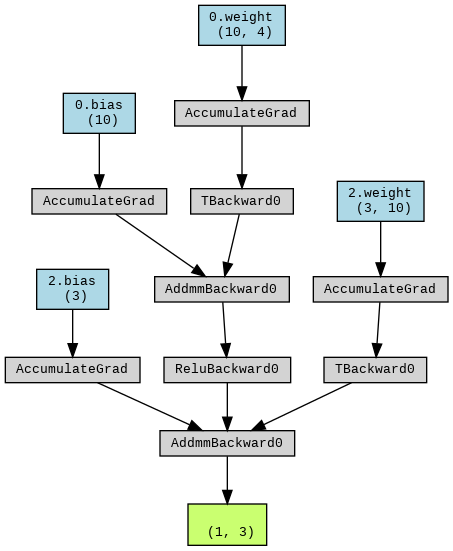

In [83]:
from IPython.display import Image
Image("iris_model.png")

<ipython-input-84-3c5c2fa49b8a>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, data_to_explain.numpy(), feature_names=dummy_df.columns)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dis

<Figure size 640x480 with 0 Axes>

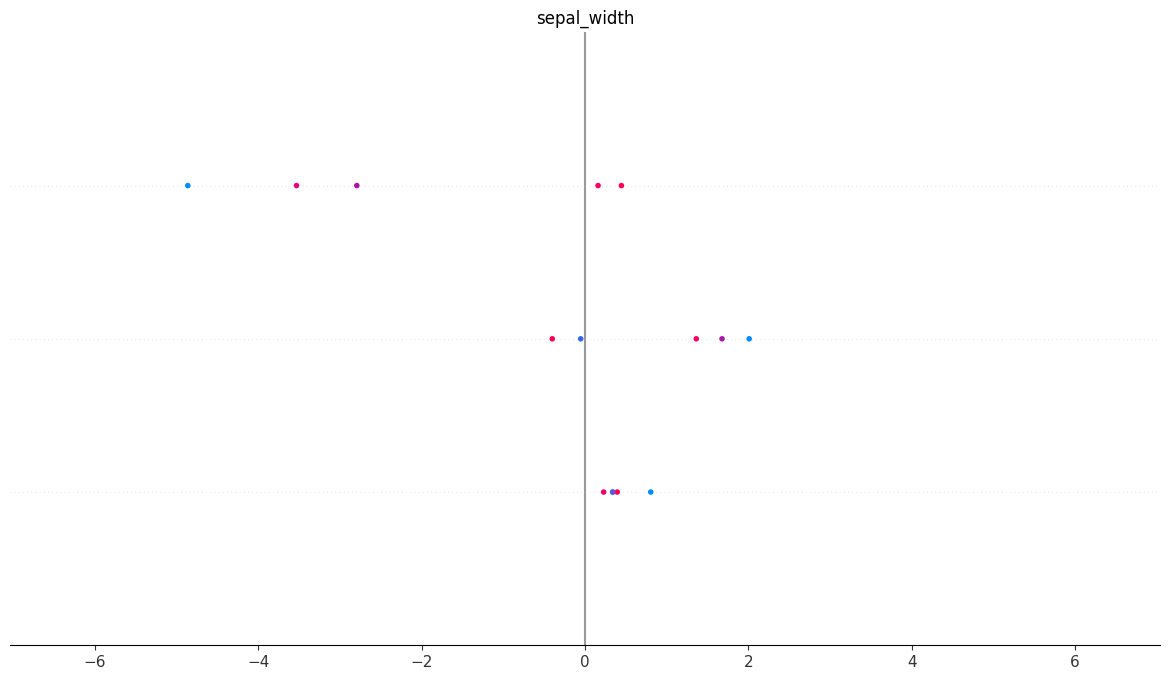

In [84]:
# SHAP Explainability
background = X_train_tensor[:20]
data_to_explain = X_test_tensor[:5]

explainer = shap.GradientExplainer(torch_model, background)
shap_values = explainer.shap_values(data_to_explain)

# Visualization
shap.summary_plot(shap_values, data_to_explain.numpy(), feature_names=dummy_df.columns)

In [85]:
# 5. Quantize the model (dynamic quantization)
quantized_model = torch.quantization.quantize_dynamic(
    torch_model, {nn.Linear}, dtype=torch.qint8
)

# 6. Evaluate the quantized model
with torch.no_grad():
    pred_quant = quantized_model(X_test_tensor).argmax(dim=1)
    acc_quant = accuracy_score(y_test_tensor, pred_quant)
    print(f"[After Quantization] Accuracy: {acc_quant * 100:.2f}%")

[After Quantization] Accuracy: 96.67%


In [86]:
import tensorflow as tf

from tensorflow import keras
from keras.layers import Dense

In [87]:
def train_model(_compiled_model, _X_train, _y_train, _X_valid, _y_valid, _model_file_name):
    _history = _compiled_model.fit(_X_train, _y_train,
                                   epochs=25,
                                   validation_data=(_X_valid, _y_valid),
                                   callbacks=[keras.callbacks.EarlyStopping(patience=2)]
                                   )
    _compiled_model.save(_model_file_name)


In [88]:
len(X_train)

120

In [89]:
X_valid, y_valid = X_train[100:], y_train[100:]

In [90]:
tf_model = keras.models.Sequential()
tf_model.add(keras.layers.Flatten(input_shape=[4]))
tf_model.add(keras.layers.Dense(4, activation="relu"))
tf_model.add(keras.layers.Dense(10, activation="relu"))
tf_model.add(keras.layers.Dense(3, activation="softmax"))

tf_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])
print(tf_model.summary())
model_file_name = 'iris_data_model.keras'

train_model(tf_model, X_train[:100], y_train[:100], X_train[100:], y_train[100:], model_file_name)

saved_model = keras.models.load_model(model_file_name)
score = saved_model.evaluate(X_test, y_test)
print('Score: ' + str(score))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103 (412.00 B)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.4430 - loss: 1.0175 - val_accuracy: 0.6500 - val_loss: 0.8804
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6239 - loss: 0.8530 - val_accuracy: 0.6500 - val_loss: 0.8016
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6800 - loss: 0.7672 - val_accuracy: 0.7000 - val_loss: 0.7282
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7231 - loss: 0.6955 - val_accuracy: 0.7000 - val_loss: 0.6846
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7281 - loss: 0.6416 - val_accuracy: 0.7500 - val_loss: 0.6328
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7535 - loss: 0.5698 - val_accuracy: 0.8000 - val_loss: 0.5537
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7783 - loss: 0.4867 - val_accuracy: 0.8000 - val_loss: 0.4660
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8096 - loss: 0.3900 - val_accuracy: 0.8000 - val_loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_32
Received: inputs=['Tensor(shape=(5, 4))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_32
Received: inputs=['Tensor(shape=(50, 4))']
  warnings.warn(msg)
<ipython-input-91-b136a17df93f>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, data_to_explain, feature_names=dummy_df.columns)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this func

<Figure size 640x480 with 0 Axes>

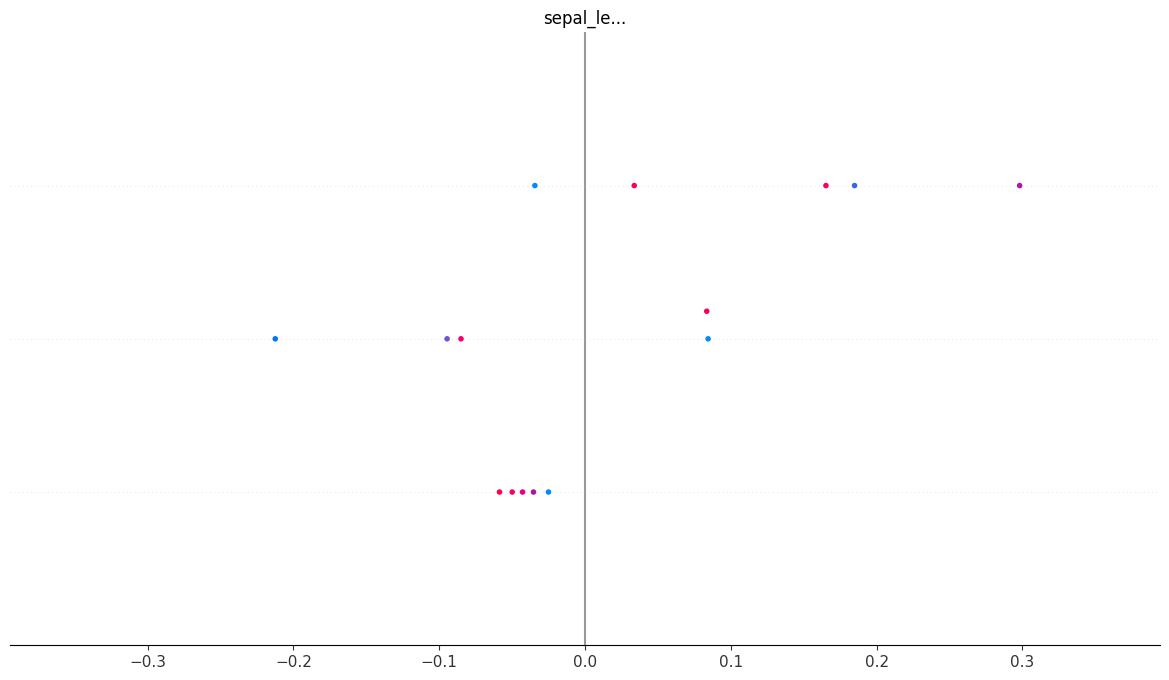

In [91]:
# SHAP Explainability
background = X_train[:20]
data_to_explain = X_test[:5]

explainer = shap.GradientExplainer(tf_model, background)
shap_values = explainer.shap_values(data_to_explain)

# Visualization
shap.summary_plot(shap_values, data_to_explain, feature_names=dummy_df.columns)

In [92]:
#shap.initjs()
explainer = shap.KernelExplainer(saved_model, background)
shap_values = explainer.shap_values(data_to_explain, nsamples=50)
#shap.plots.force(explainer.expected_value[0], shap_values[..., 0], feature_names=dummy_df.columns)

  0%|          | 0/5 [00:00<?, ?it/s]